In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
twitter_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "twitter"]

In [7]:
twitter_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
3030,twitter,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031
3031,twitter,2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032
3032,twitter,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033
3033,twitter,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034
3034,twitter,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035
...,...,...,...,...,...,...,...,...,...
5208,twitter,2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209
5209,twitter,2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210
5210,twitter,2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211
5211,twitter,2022-07-11,34.599998,34.900002,32.549999,32.650002,32.650002,67071300,5212


In [8]:
end_date = twitter_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
twitter_price['date'] = pd.to_datetime(twitter_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
twitter_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
twitter_price.set_index("date",inplace = True)

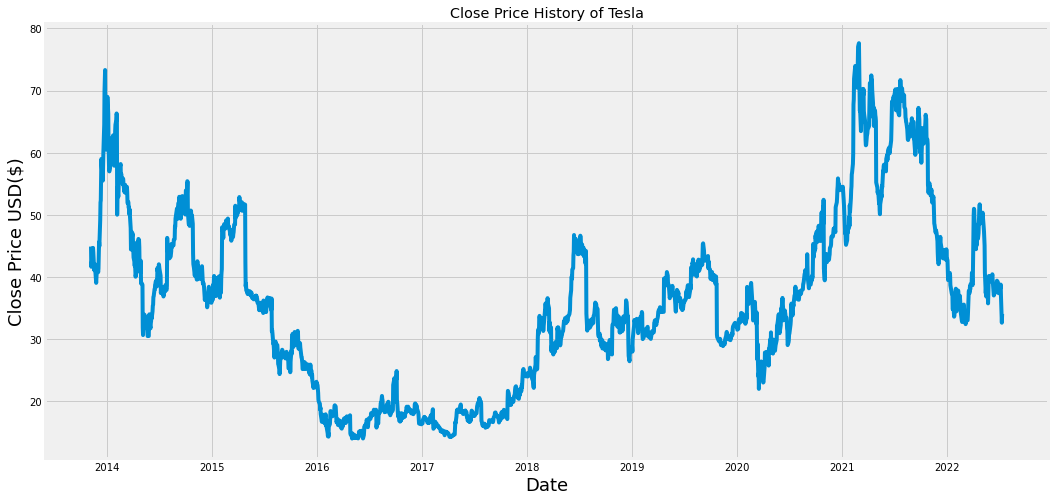

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(twitter_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = twitter_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1747, 1), (436, 1))

In [17]:
train

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998
...,...
2020-10-09,45.900002
2020-10-12,48.250000
2020-10-13,47.000000


In [18]:
test

,close
date,
2020-10-16,45.810001
2020-10-19,45.820000
2020-10-20,46.349998
2020-10-21,50.240002
2020-10-22,50.279999
...,...
2022-07-06,38.209999
2022-07-07,38.790001
2022-07-08,36.810001


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.3583779 ],
       [0.29298967],
       [0.3151525 ]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1746, 1747)

In [21]:
train_scaled.shape,test_scaled.shape

((1747, 1), (436, 1))

In [22]:
train_scaled

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.51854765],
       [0.50251496],
       [0.50330086]])

In [23]:
test_scaled

array([[0.49984286],
       [0.50000002],
       [0.50833071],
       [0.56947507],
       [0.57010375],
       [0.57261868],
       [0.54998431],
       [0.58566491],
       [0.54259668],
       [0.60389817],
       [0.4298963 ],
       [0.40018865],
       [0.43571206],
       [0.45190191],
       [0.46683434],
       [0.45756052],
       [0.4586608 ],
       [0.44640052],
       [0.4655769 ],
       [0.45268787],
       [0.46321914],
       [0.45143039],
       [0.45331656],
       [0.46086142],
       [0.46541969],
       [0.48208113],
       [0.48616788],
       [0.49072621],
       [0.5095882 ],
       [0.51210314],
       [0.51084564],
       [0.51336057],
       [0.52216287],
       [0.53096515],
       [0.53002203],
       [0.53269418],
       [0.52530653],
       [0.52216287],
       [0.5847218 ],
       [0.58833701],
       [0.59745366],
       [0.61002832],
       [0.62904748],
       [0.63847851],
       [0.65796921],
       [0.63863566],
       [0.64287963],
       [0.633

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 160
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1586, 160)
(1586,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(275, 160)
(275,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1586, 160, 1)
(1586,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(275, 160, 1)
(275,)


(None, None)

In [31]:
X_test

array([[[0.49984286],
        [0.50000002],
        [0.50833071],
        ...,
        [0.67588809],
        [0.70716759],
        [0.71707015]],

       [[0.50000002],
        [0.50833071],
        [0.56947507],
        ...,
        [0.70716759],
        [0.71707015],
        [0.70418112]],

       [[0.50833071],
        [0.56947507],
        [0.57010375],
        ...,
        [0.71707015],
        [0.70418112],
        [0.71832759]],

       ...,

       [[0.61207172],
        [0.59886832],
        [0.57529083],
        ...,
        [0.38069791],
        [0.38305568],
        [0.38038353]],

       [[0.59886832],
        [0.57529083],
        [0.54369694],
        ...,
        [0.38305568],
        [0.38038353],
        [0.38950019]],

       [[0.57529083],
        [0.54369694],
        [0.54055334],
        ...,
        [0.38038353],
        [0.38950019],
        [0.3583779 ]]])

In [32]:
ytest

array([0.70418112, 0.71832759, 0.7276014 , 0.73074508, 0.73593216,
       0.72650113, 0.72178564, 0.73404592, 0.73624647, 0.75369383,
       0.78230118, 0.82489784, 0.85256213, 0.84753226, 0.85319088,
       0.86435087, 0.86136436, 0.85036158, 0.86749449, 0.88337004,
       0.86057851, 0.83024213, 0.86387934, 0.87786865, 0.87378184,
       0.8843131 , 0.84973283, 0.82364047, 0.81751021, 0.84768948,
       0.87283879, 0.87331032, 0.90663321, 0.85947822, 0.85381963,
       0.87944045, 0.88588503, 0.87613962, 0.86639421, 0.85853505,
       0.85963533, 0.86875199, 0.83873005, 0.83307143, 0.81216602,
       0.80870798, 0.8006916 , 0.79864826, 0.78230118, 0.76815472,
       0.75620876, 0.75510848, 0.76249611, 0.78780257, 0.78544487,
       0.78843132, 0.76391077, 0.77679979, 0.79676201, 0.7936184 ,
       0.81012269, 0.7951902 , 0.79613339, 0.80116324, 0.75856652,
       0.76155299, 0.74740653, 0.71754169, 0.72587239, 0.75180764,
       0.75888091, 0.76171021, 0.73781835, 0.76658286, 0.78968

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 160
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
50/50 [==============================] - 20s 199ms/step - loss: 0.0089
Epoch 2/100
50/50 [==============================] - 9s 174ms/step - loss: 0.0022
Epoch 3/100
50/50 [==============================] - 10s 201ms/step - loss: 0.0019
Epoch 4/100
50/50 [==============================] - 11s 228ms/step - loss: 0.0016
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 0.0015
Epoch 6/100
50/50 [==============================] - 12s 237ms/step - loss: 0.0014
Epoch 7/100
50/50 [==============================] - 12s 240ms/step - loss: 0.0013
Epoch 8/100
50/50 [==============================] - 11s 221ms/step - loss: 0.0011
Epoch 9/100
50/50 [==============================] - 10s 195ms/step - loss: 0.0010
Epoch 10/100
50/50 [==============================] - 10s 197ms/step - loss: 9.8106e-04
Epoch 11/100
50/50 [==============================] - 10s 195ms/step - loss: 8.8041e-04
Epoch 12/100
50/50 [==============================] - 9s 184ms/step - loss: 7.

50/50 [==============================] - 9s 186ms/step - loss: 2.7771e-04
Epoch 96/100
50/50 [==============================] - 9s 182ms/step - loss: 2.9575e-04
Epoch 97/100
50/50 [==============================] - 9s 175ms/step - loss: 3.1323e-04
Epoch 98/100
50/50 [==============================] - 9s 175ms/step - loss: 2.9269e-04
Epoch 99/100
50/50 [==============================] - 9s 182ms/step - loss: 3.0467e-04
Epoch 100/100
50/50 [==============================] - 9s 178ms/step - loss: 2.7097e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

9/9 [==============================] - 1s 67ms/step


In [38]:
test_predict

array([[0.6920206 ],
       [0.6806201 ],
       [0.69950294],
       [0.70359117],
       [0.70695627],
       [0.7125636 ],
       [0.7021043 ],
       [0.7008558 ],
       [0.7131286 ],
       [0.7113568 ],
       [0.7304468 ],
       [0.75434905],
       [0.7917197 ],
       [0.8111981 ],
       [0.8060322 ],
       [0.81897193],
       [0.82737213],
       [0.8229857 ],
       [0.81510425],
       [0.8347271 ],
       [0.8416286 ],
       [0.8171369 ],
       [0.7967658 ],
       [0.8350056 ],
       [0.8304162 ],
       [0.8297715 ],
       [0.8421005 ],
       [0.8026362 ],
       [0.7916415 ],
       [0.78504294],
       [0.81329083],
       [0.8259075 ],
       [0.82401377],
       [0.86116236],
       [0.80190647],
       [0.82322526],
       [0.83712006],
       [0.8366821 ],
       [0.82920814],
       [0.8233572 ],
       [0.81671685],
       [0.8186404 ],
       [0.8253428 ],
       [0.79167825],
       [0.798662  ],
       [0.77111286],
       [0.7752222 ],
       [0.762

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.016442843087485223

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.030682119473707265

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.023134586044822797

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.03993560146233313

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

3.99


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[58.036346],
       [57.311047],
       [58.512375],
       [58.77247 ],
       [58.986553],
       [59.343292],
       [58.67787 ],
       [58.598442],
       [59.379242],
       [59.266518],
       [60.48102 ],
       [62.001682],
       [64.3792  ],
       [65.61842 ],
       [65.289764],
       [66.11299 ],
       [66.647415],
       [66.368355],
       [65.86693 ],
       [67.11534 ],
       [67.55441 ],
       [65.99625 ],
       [64.70024 ],
       [67.13306 ],
       [66.84107 ],
       [66.800064],
       [67.584435],
       [65.073715],
       [64.37423 ],
       [63.954433],
       [65.75156 ],
       [66.55424 ],
       [66.433754],
       [68.79715 ],
       [65.02728 ],
       [66.38359 ],
       [67.26758 ],
       [67.23971 ],
       [66.76422 ],
       [66.39198 ],
       [65.96953 ],
       [66.0919  ],
       [66.5183  ],
       [64.37657 ],
       [64.82088 ],
       [63.068195],
       [63.32963 ],
       [62.501244],
       [62.540737],
       [61.35211 ],


In [46]:
test_predict.shape

(275, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2021-06-09    59.709999
2021-06-10    60.299999
2021-06-11    60.500000
2021-06-14    60.830002
2021-06-15    60.230000
                ...    
2022-07-06    38.209999
2022-07-07    38.790001
2022-07-08    36.810001
2022-07-11    32.650002
2022-07-12    34.060001
Name: close, Length: 275, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2021-06-09    58.036346
2021-06-10    57.311047
2021-06-11    58.512375
2021-06-14    58.772469
2021-06-15    58.986553
                ...    
2022-07-06    38.014679
2022-07-07    38.225201
2022-07-08    38.061768
2022-07-11    38.617737
2022-07-12    36.665188
Length: 275, dtype: float32

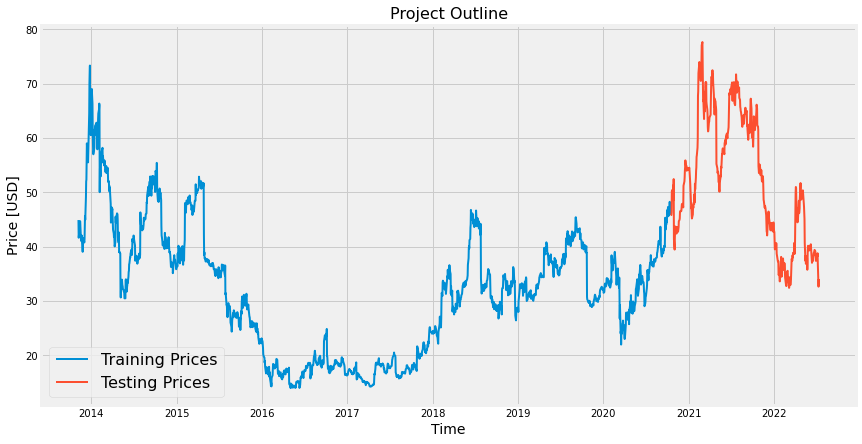

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

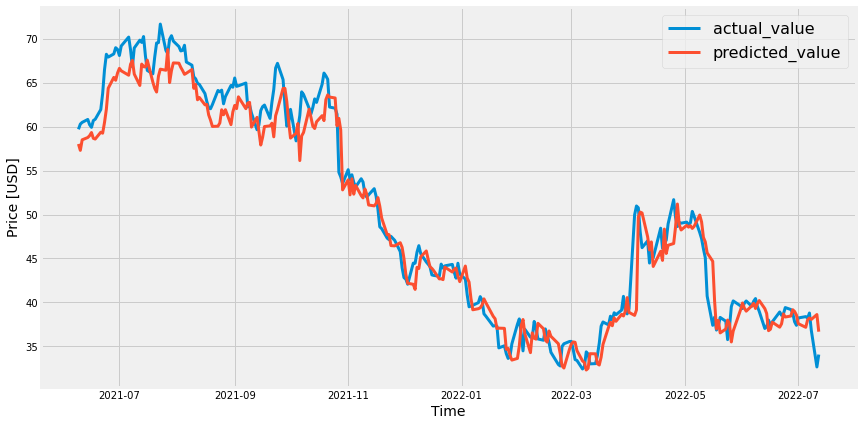

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

436

In [52]:
length = len(test_scaled)
length

436

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-160:]
fut_inp.shape

(160, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 160)

In [56]:
fut_inp

array([[0.54055334, 0.52342035, 0.5207482 , 0.52672118, 0.51964793,
        0.49937127, 0.47044955, 0.45284504, 0.45017295, 0.44105629,
        0.4787803 , 0.47862308, 0.49842821, 0.51005974, 0.49591327,
        0.48082363, 0.47689405, 0.47249295, 0.45771774, 0.45677462,
        0.45535997, 0.47705128, 0.46982086, 0.4739076 , 0.47657975,
        0.46243322, 0.45190191, 0.47862308, 0.45913239, 0.45033011,
        0.4218799 , 0.40066019, 0.40207484, 0.40333227, 0.40804782,
        0.41889345, 0.41244893, 0.38808554, 0.38399874, 0.36607985,
        0.36686575, 0.36576548, 0.32709841, 0.33087083, 0.31688147,
        0.3082364 , 0.31169445, 0.33417166, 0.36938068, 0.37896888,
        0.35366236, 0.32175418, 0.36042125, 0.34627479, 0.34533167,
        0.37441061, 0.36262187, 0.34313111, 0.34077334, 0.36105   ,
        0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.54055334, 0.52342035, 0.5207482 , 0.52672118, 0.51964793,
        0.49937127, 0.47044955, 0.45284504, 0.45017295, 0.44105629,
        0.4787803 , 0.47862308, 0.49842821, 0.51005974, 0.49591327,
        0.48082363, 0.47689405, 0.47249295, 0.45771774, 0.45677462,
        0.45535997, 0.47705128, 0.46982086, 0.4739076 , 0.47657975,
        0.46243322, 0.45190191, 0.47862308, 0.45913239, 0.45033011,
        0.4218799 , 0.40066019, 0.40207484, 0.40333227, 0.40804782,
        0.41889345, 0.41244893, 0.38808554, 0.38399874, 0.36607985,
        0.36686575, 0.36576548, 0.32709841, 0.33087083, 0.31688147,
        0.3082364 , 0.31169445, 0.33417166, 0.36938068, 0.37896888,
        0.35366236, 0.32175418, 0.36042125, 0.34627479, 0.34533167,
        0.37441061, 0.36262187, 0.34313111, 0.34077334, 0.36105   ,
        0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.5405533420569006,
 0.5234203484794253,
 0.5207482012298742,
 0.5267211817064373,
 0.5196479339664224,
 0.4993712747267183,
 0.47044955063421323,
 0.4528450386440602,
 0.45017295426782233,
 0.4410562924107021,
 0.4787802960757762,
 0.4786230813560082,
 0.4984282064647063,
 0.5100597379782963,
 0.49591327393492324,
 0.48082363160124,
 0.47689404952345393,
 0.4724929490329902,
 0.45771773613884315,
 0.45677462072184616,
 0.4553599711738432,
 0.4770512799615503,
 0.46982086465675243,
 0.4739075985809932,
 0.4765797458305443,
 0.462433218913858,
 0.45190190750873493,
 0.4786230813560082,
 0.4591323856868462,
 0.45033010611427704,
 0.4218799004344498,
 0.4006601886510619,
 0.402074838199065,
 0.4033322730272998,
 0.408047818675628,
 0.41889344949198903,
 0.4124489348844199,
 0.38808554172047505,
 0.38399874492292096,
 0.3660798506482167,
 0.3668657513454455,
 0.3657654840819937,
 0.32709841215490776,
 0.3308708266679107,
 0.3168814673160075,
 0.3082364024632066,
 0.31169445040998667,
 0.3

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=160
i=0
while(i<30):
    
    if(len(tmp_inp)>160):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.30812868475914], [0.30582574009895325], [0.3041519224643707], [0.3027026355266571], [0.3011774718761444], [0.2994649112224579], [0.2975657880306244], [0.2955389618873596], [0.29346123337745667], [0.2914018929004669], [0.28940942883491516], [0.28750813007354736], [0.28570058941841125], [0.2839747369289398], [0.2823099195957184], [0.2806834578514099], [0.2790750563144684], [0.2774691581726074], [0.27585646510124207], [0.27423295378685], [0.27259960770606995], [0.27096056938171387], [0.26932191848754883], [0.2676907479763031], [0.2660735249519348], [0.26447632908821106], [0.26290377974510193], [0.26135924458503723], [0.2598450481891632], [0.2583622336387634]]


In [62]:
end_date

'2022-07-12'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[33.613146  ],
       [33.46663267],
       [33.36014439],
       [33.26794076],
       [33.17090986],
       [33.06195675],
       [32.94113454],
       [32.81218787],
       [32.68000279],
       [32.54898755],
       [32.42222699],
       [32.30126637],
       [32.18627064],
       [32.07647191],
       [31.97055624],
       [31.86708075],
       [31.76475425],
       [31.66258701],
       [31.55998748],
       [31.4566997 ],
       [31.35278622],
       [31.24851061],
       [31.14425965],
       [31.04048458],
       [30.93759686],
       [30.83598326],
       [30.73593768],
       [30.63767436],
       [30.54134119],
       [30.44700453]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12    33.613146
2022-07-13    33.466633
2022-07-14    33.360144
2022-07-15    33.267941
2022-07-18    33.170910
2022-07-19    33.061957
2022-07-20    32.941135
2022-07-21    32.812188
2022-07-22    32.680003
2022-07-25    32.548988
2022-07-26    32.422227
2022-07-27    32.301266
2022-07-28    32.186271
2022-07-29    32.076472
2022-08-01    31.970556
2022-08-02    31.867081
2022-08-03    31.764754
2022-08-04    31.662587
2022-08-05    31.559987
2022-08-08    31.456700
2022-08-09    31.352786
2022-08-10    31.248511
2022-08-11    31.144260
2022-08-12    31.040485
2022-08-15    30.937597
2022-08-16    30.835983
2022-08-17    30.735938
2022-08-18    30.637674
2022-08-19    30.541341
2022-08-22    30.447005
Freq: B, dtype: float64

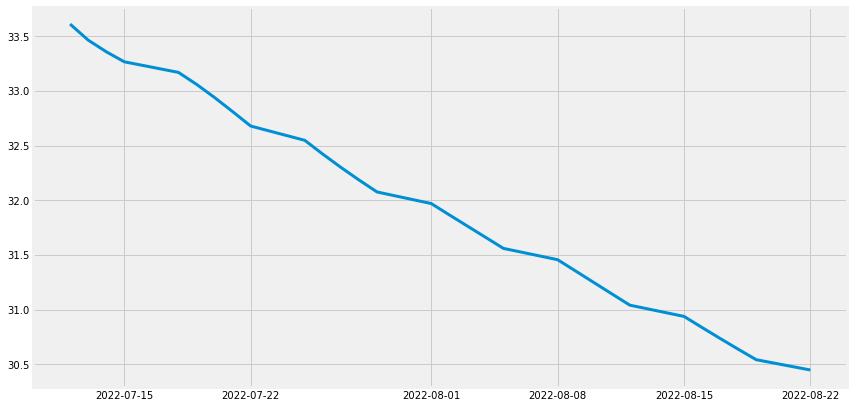

In [69]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

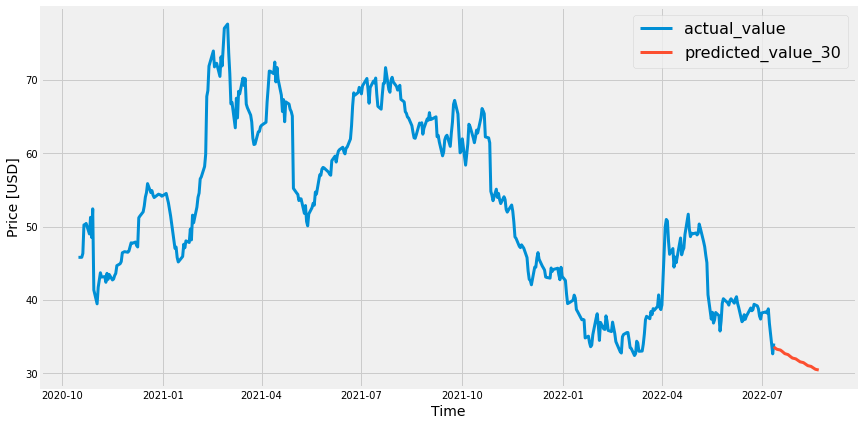

In [70]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)